# Классификация текстов

##### Автор: Виктор Китов ([DeepMachineLearning.ru](https://deepmachinelearning.ru))

##### Лицензия: BSD-3-Clause

В этом ноутбуке изучим подготовку текстовых данных для анализа и сравним различные методы классификации текстов, используя датасет **BBC News Archive**. 

Этот набор данных содержит более 2000 статей, распределенных по 5 тематическим категориям: *Business, Entertainment, Politics, Sport* и *Tech*. 

### В ходе семинара мы пройдем через следующие этапы:

1.  **Реализуем собственный токенизатор, который выполняет нормализацию регистра и очистку от пунктуации.**

2.  **Попробуем различные способы кодирования текста:**
    *   **Binary:** Проверим гипотезу, достаточно ли модели знать только сам факт наличия слова в тексте.
    *   **TF (Term Frequency):** Оценим значимость частоты повторения слов.
    *   **TF-IDF:** Применим статистический вес для уменьшения влияния общеупотребимых слов и выделения уникальных терминов.

3.  **Оптимизация словаря и борьба с шумом:**
    *   Изучим влияние параметра `min_df` для отсечения редких слов и опечаток.

4.  **Снижение размерности (LSA):**
    *   Применим метод **Latent Semantic Analysis (TruncatedSVD)**, чтобы сжать тысячи слов в компактное векторное пространство «скрытых тем» и сравним результат с полными векторами признаков.

5.  **Сравнительный анализ моделей классификации:**
    *   Протестируем спектр алгоритмов: от вероятностного **Naive Bayes** и линейных **Logistic Regression / SGD** до древовидного ансамбля **Random Forest**.
    *   Для каждой пары «кодировка + модель» проведем автоматический подбор гиперпараметров через **GridSearchCV**.


In [30]:
import string
import re
import time
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Инструменты для работы с текстом
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Модели классификации
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Инструменты для построения пайплайнов и поиска параметров
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Метрики
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATASET = '/data/DATASETS/TEXT/CLASSIFICATION/'

In [3]:
def tokenizer(text):
    # 1. Приведение к нижнему регистру
    text = text.lower()
    # 2. Удаление пунктуации с помощью регулярных выражений или таблицы трансляции
    # string.punctuation содержит !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    # 3. Удаление лишних пробелов и разрыв по пробелам
    tokens = text.split()
    return tokens

# Проверка:
print(tokenizer("Hello, World! This is a BBC-news article..."))
# Результат: ['hello', 'world', 'this', 'is', 'a', 'bbcnews', 'article']

['hello', 'world', 'this', 'is', 'a', 'bbcnews', 'article']


In [4]:
# Загрузка (укажите ваш путь к файлу)
df = pd.read_csv(PATH_TO_DATASET+'bbc-news-data.csv', sep='\t')

In [5]:
# Объединяем заголовок и контент для лучшего результата
df['text'] = df['title'] + " " + df['content']

# Кодируем категории (business -> 0, tech -> 1 и т.д.)
le = LabelEncoder()
y = le.fit_transform(df['category'])
class_names = le.classes_

# Разбиваем на train/test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['text'], y, test_size=0.2, random_state=42, stratify=y
)

print(f"Загружено документов: {len(df)}")
print(f"Классы: {class_names}")

Загружено документов: 2225
Классы: ['business' 'entertainment' 'politics' 'sport' 'tech']


In [6]:
X_train_raw.shape, y_train.shape

((1780,), (1780,))

In [7]:
X_train_raw

141     Asian banks halt dollar's slide  The dollar re...
1399    GB quartet get cross country call  Four Britis...
807     Spider-Man creator wins profits  Spider-Man cr...
1054    Howard unveils election platform  The Conserva...
1080    Police probe BNP mosque leaflet  Police are in...
                              ...                        
1048    Clarke to unveil immigration plan  New control...
797     Rapper 50 Cent ends protege feud  Rapper 50 Ce...
1948    The Force is strong in Battlefront  The warm r...
1660    Owen set for skipper role  Wales number eight ...
512     Musical treatment for Capra film  The classic ...
Name: text, Length: 1780, dtype: object

In [8]:
y_train

array([0, 3, 1, ..., 4, 3, 1], shape=(1780,))

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(y, title, class_names=None):
    """
    Визуализирует распределение классов.
    y: массив меток (indices или strings)
    title: заголовок графика
    class_names: список имен классов (если y содержит индексы)
    """
    # 1. Считаем количество вхождений
    unique, counts = np.unique(y, return_counts=True)
    
    # 2. Определяем подписи для оси X
    # Если переданы class_names и y содержит индексы
    if class_names is not None:
        labels = [class_names[i] for i in unique]
    else:
        labels = unique

    # 3. Настройка стиля
    plt.figure(figsize=(7, 5))
    colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(labels)))
    
    bars = plt.bar(labels, counts, color=colors, edgecolor='black', alpha=0.8)
    
    # Добавляем числа над столбцами
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), 
                     textcoords="offset points",
                     ha='center', va='bottom', fontweight='bold')

    plt.title(title, fontsize=14, pad=15)
    plt.ylabel('Количество документов')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

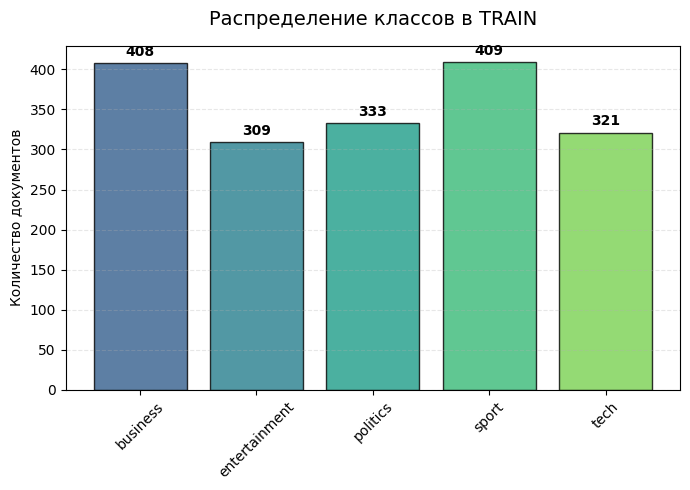

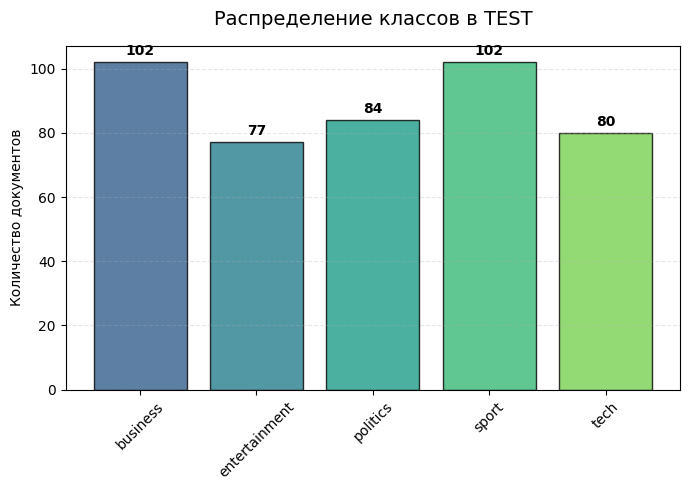

In [10]:
# Для тренировочной выборки
plot_class_distribution(y_train, "Распределение классов в TRAIN", class_names=class_names)

# Для тестовой выборки
plot_class_distribution(y_test, "Распределение классов в TEST", class_names=class_names)

# Функции оценки качества и показа результатов

In [17]:
def test_model(model, X_raw, y_true, title, verbose=True):
    """
    Тестирование текстовой модели.
    model: обученный Pipeline
    X_raw: сырые текстовые данные
    y_true: реальные метки
    title: заголовок эксперимента
    verbose: если True — выводит графики и отчеты, если False — только возвращает Accuracy
    """
    # Предсказание
    y_pred = model.predict(X_raw)
    acc = accuracy_score(y_true, y_pred)
    
    if verbose:
        print("\n" + "="*50)
        print(f"РЕЗУЛЬТАТЫ: {title}")
        print("="*50)
        print(f"Accuracy: {acc:.4f}")
        
        # # Отчет по классам (используем глобальный class_names)
        # print("\nДетальный отчет:")
        # print(classification_report(y_true, y_pred, target_names=class_names))
        
        # # Матрица ошибок
        # cm = confusion_matrix(y_true, y_pred)
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
        #             xticklabels=class_names, yticklabels=class_names)
        # plt.title(f'Confusion Matrix: {title}')
        # plt.ylabel('Реальность')
        # plt.xlabel('Предсказано')
        # plt.show()
    
    return acc

In [20]:
def plot_experiment_results(args, accuracies, title, x_label="Параметр", y_label="Accuracy"):
    """
    Визуализатор результатов экспериментов.
    """
    plt.figure(figsize=(12, 6), dpi=100)
    
    # Преобразуем в numpy для удобства
    args = np.array(args)
    accuracies = np.array(accuracies)
    
    # Строим график
    plt.plot(args, accuracies, marker='o', linestyle='-', color='#2c3e50', 
             linewidth=2.5, markersize=8, markerfacecolor='#e74c3c', label='Accuracy')

    # Подписываем каждое значение над точкой
    for i, acc in enumerate(accuracies):
        plt.annotate(f"{acc:.4f}", 
                     (args[i], accuracies[i]), 
                     xytext=(0, 10), 
                     textcoords='offset points', 
                     ha='center', 
                     fontsize=10, 
                     fontweight='bold')

    # Выделяем лучший результат зеленым кружком
    best_idx = np.argmax(accuracies)
    plt.scatter(args[best_idx], accuracies[best_idx], s=200, facecolors='none', 
                edgecolors='#27ae60', linewidths=2, label='Лучший результат', zorder=5)

    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Поворачиваем подписи на оси X
    plt.xticks(rotation=45, ha='right')
    
    # Динамические границы оси Y
    y_min, y_max = accuracies.min(), accuracies.max()
    padding = (y_max - y_min) * 0.2 if y_max != y_min else 0.05
    plt.ylim(y_min - padding, min(1.0, y_max + padding))

    plt.legend()
    plt.tight_layout()
    plt.show()

# Сравнение моделей

In [25]:
# Порог отсечения редких слов
MIN_DF = 5 

# 1. Список векторизаторов 
vectorizers = [
    ("Binary", CountVectorizer(binary=True, min_df=MIN_DF, tokenizer=tokenizer, token_pattern=None)),
    ("TF", CountVectorizer(binary=False, min_df=MIN_DF, tokenizer=tokenizer, token_pattern=None)),
    ("TF-IDF", TfidfVectorizer(min_df=MIN_DF, tokenizer=tokenizer, token_pattern=None))
]

# 2. Обновленный список моделей
models = [
    ("Naive Bayes", MultinomialNB(), 
     {'clf__alpha': [0.1, 1.0]}),
    
    ("LogReg", LogisticRegression(max_iter=1000, random_state=42), 
     {'clf__C': [0.1, 1.0, 10.0]}),
    
    ("SGD (SVM)", SGDClassifier(random_state=42), 
     {'clf__alpha': [1e-4, 1e-3]}),
    
    ("RandomForest", RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42), 
     {'clf__max_features': [0.01, 0.05, 0.1, 'sqrt']}) # подбор доли признаков
]

In [26]:
all_results = []

for vec_name, vec in vectorizers:
    print(f"\n>>> Кодировка: {vec_name}")
    print(f"  {'Модель':<15} | {'Acc':<8} | {'Словарь':<8} | {'Параметры'}")
    print(f"  {'-'*15}-|-{'-'*8}-|-{'-'*8}-|-{'-'*20}")
    
    for model_name, clf, params in models:
        title = f"{vec_name} + {model_name}"
        
        pipe = Pipeline([
            ('vectorizer', vec),
            ('clf', clf)
        ])
        
        # GridSearch
        grid = GridSearchCV(pipe, params, cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_raw, y_train)
        
        # Тестируем (verbose=False)
        # Нам нужно передать X_test_raw, так как векторизатор внутри Pipeline
        acc = test_model(grid.best_estimator_, X_test_raw, y_test, title, verbose=False)
        
        # Сохраняем все данные
        vocab_size = len(grid.best_estimator_.named_steps['vectorizer'].get_feature_names_out())
        all_results.append({
            'label': title,
            'accuracy': acc,
            'model_obj': grid.best_estimator_,
            'vocab_size': vocab_size,
            'best_params': grid.best_params_
        })
        
        print(f"  - {model_name:<13} | {acc:<8.4f} | {vocab_size:<8} | {grid.best_params_}")

# Сортируем по точности
all_results = sorted(all_results, key=lambda x: x['accuracy'], reverse=True)


>>> Кодировка: Binary
  Модель          | Acc      | Словарь  | Параметры
  ----------------|----------|----------|---------------------
  - Naive Bayes   | 0.9775   | 8512     | {'clf__alpha': 0.1}
  - LogReg        | 0.9865   | 8512     | {'clf__C': 1.0}
  - SGD (SVM)     | 0.9798   | 8512     | {'clf__alpha': 0.001}
  - RandomForest  | 0.9663   | 8512     | {'clf__max_features': 0.01}

>>> Кодировка: TF
  Модель          | Acc      | Словарь  | Параметры
  ----------------|----------|----------|---------------------
  - Naive Bayes   | 0.9775   | 8512     | {'clf__alpha': 1.0}
  - LogReg        | 0.9753   | 8512     | {'clf__C': 1.0}
  - SGD (SVM)     | 0.9798   | 8512     | {'clf__alpha': 0.001}
  - RandomForest  | 0.9596   | 8512     | {'clf__max_features': 'sqrt'}

>>> Кодировка: TF-IDF
  Модель          | Acc      | Словарь  | Параметры
  ----------------|----------|----------|---------------------
  - Naive Bayes   | 0.9798   | 8512     | {'clf__alpha': 0.1}
  - LogReg        

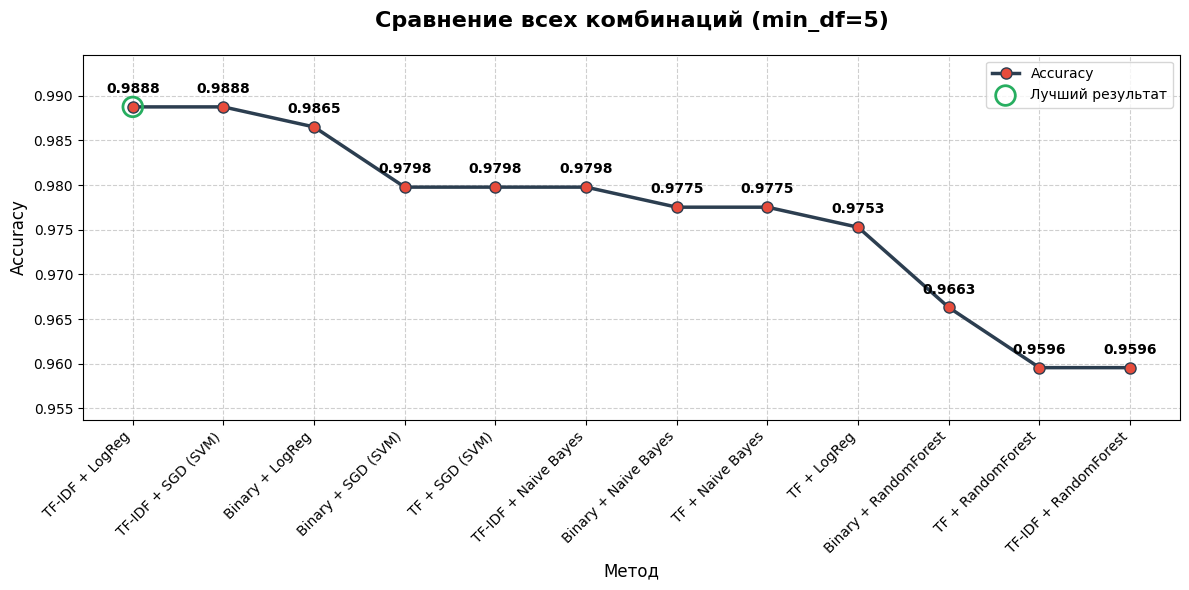



ЛУЧШИЙ МЕТОД: TF-IDF + LogReg

РЕЗУЛЬТАТЫ: TF-IDF + LogReg
Accuracy: 0.9888


In [27]:
# 1. Общий график сравнения
plot_experiment_results(
    args=[res['label'] for res in all_results], 
    accuracies=[res['accuracy'] for res in all_results], 
    title=f"Сравнение всех комбинаций (min_df={MIN_DF})",
    x_label="Метод"
)

# 2. Детальный разбор Победителя
best = all_results[0]
print(f"\n\nЛУЧШИЙ МЕТОД: {best['label']}")
test_model(best['model_obj'], X_test_raw, y_test, best['label'], verbose=True);

# Влияние размера словаря на качество
Размер словаря будем настраивать гиперпараметром `min_df`, задающим нижнюю границу встречаемости слова в датасете для того, чтобы оно попало в словарь и учитывалось в признаках.

In [ ]:
# 1. Список значений min_df для тестирования
# От 1 (учитываем все слова) до 100 (только очень частые слова)
min_df_values = [1, 2, 5, 10, 20, 50, 100]
accuracies = []
vocab_sizes = []

print(f"{'min_df':<8} | {'Accuracy':<10} | {'Словарь':<10} | {'Время (сек)'}")
print("-" * 45)

for m_df in min_df_values:
    start_time = time.time()
    
    # Создаем Pipeline или просто последовательно векторизуем
    # Используем ваш tokenizer
    vec = TfidfVectorizer(min_df=m_df, tokenizer=tokenizer, token_pattern=None)
    
    # Трансформируем данные
    X_train_tfidf = vec.fit_transform(X_train_raw)
    X_test_tfidf = vec.transform(X_test_raw)
    
    # Обучаем лучшую модель
    model = LogisticRegression(C=10.0, max_iter=1000, random_state=42, n_jobs=-1)
    model.fit(X_train_tfidf, y_train)
    
    # Оцениваем
    acc = model.score(X_test_tfidf, y_test)
    vocab_size = len(vec.get_feature_names_out())
    
    accuracies.append(acc)
    vocab_sizes.append(vocab_size)
    
    end_time = time.time()
    print(f"{m_df:<8} | {acc:<10.4f} | {vocab_size:<10} | {end_time - start_time:.2f}")

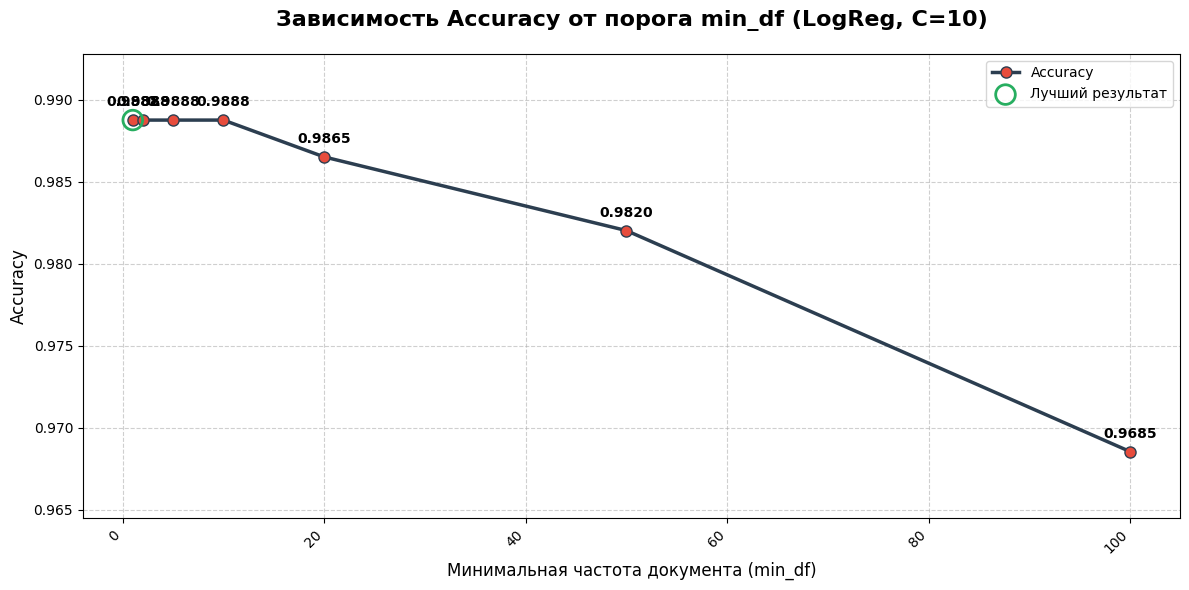

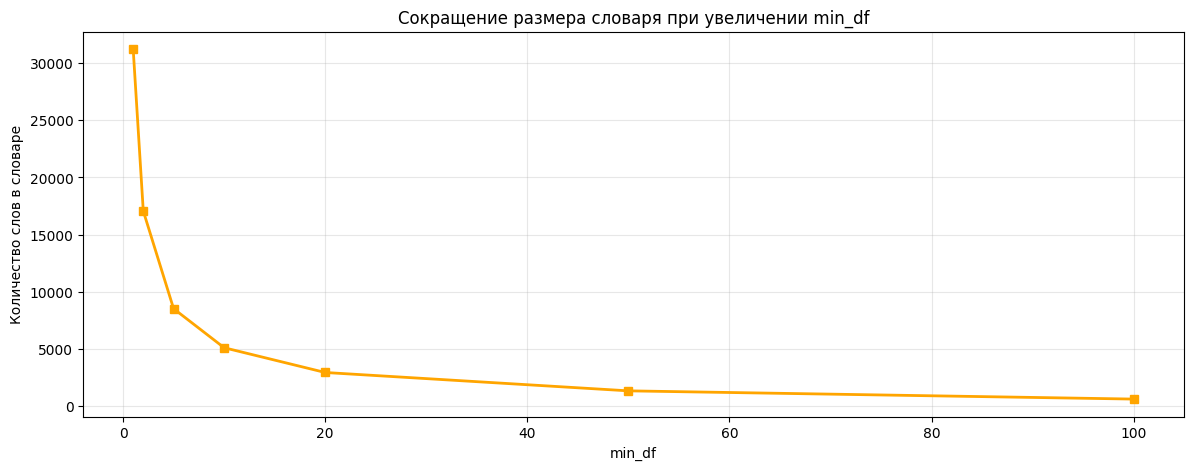

In [38]:
# 2. Визуализация результатов с помощью вашей функции
plot_experiment_results(
    args=min_df_values, 
    accuracies=accuracies, 
    title="Зависимость Accuracy от порога min_df (LogReg, C=10)",
    x_label="Минимальная частота документа (min_df)"
)

# 3. Дополнительный график: как уменьшается словарь
plt.figure(figsize=(14.2, 5))
plt.plot(min_df_values, vocab_sizes, marker='s', color='orange', linewidth=2)
plt.title("Сокращение размера словаря при увеличении min_df")
plt.xlabel("min_df")
plt.ylabel("Количество слов в словаре")
plt.grid(True, alpha=0.3)
plt.show()

# Тематическое моделирование

- Применим модель Latent Dirichlet Allocation, чтобы извлечь основные темы документов.
- Каждый документ будем представлять не вектором представленности слов, а вектором представленности тем.
- Оценим качество модели на тематических признаках.
- Визуализируем найденные темы, показав в каждой самые часто встречающиеся слова.

Метод LDA работает на счётчиках слов (TF представлении документов).

In [54]:
from sklearn.decomposition import LatentDirichletAllocation

# # Используем CountVectorizer (LDA работает со счётчиками слов)
# vec_count = CountVectorizer(min_df=5, tokenizer=tokenizer, token_pattern=None)

vec_count = CountVectorizer(
    min_df=5, 
    max_df=0.5,           # Удаляем слишком частые слова
    stop_words='english', # Добавляем стандартные стоп-слова
    tokenizer=tokenizer, 
    token_pattern=None
)

# # Настройка LDA
# lda = LatentDirichletAllocation(n_components=50,   # число тем для поиска
#                                 random_state=42, learning_method='online')

lda = LatentDirichletAllocation(
    n_components=50,
    topic_word_prior=0.01, # Снижаем (дефолт ~1/(#тем)). Делает темы более "резкими"
    doc_topic_prior=0.01,  # Снижаем. Заставляет документ сильнее тяготеть к одной теме
    max_iter=20,           # Даем больше итераций для "кристаллизации" тем
    learning_method='online',
    learning_offset=50.,
    random_state=42,
    n_jobs=-1              # Параллелим на все ядра
)

# Собираем Pipeline
lda_pipe = Pipeline([
    ('count', vec_count),
    ('lda', lda),
    ('clf', LogisticRegression(C=10.0, max_iter=1000, random_state=42))
])

print("Обучение модели CountVectorizer+LDA+LogReg...")
lda_pipe.fit(X_train_raw, y_train)

# 4. Тестирование
test_model(lda_pipe, X_test_raw, y_test, "CountVectorizer+LDA+LogReg", verbose=True)

Обучение модели CountVectorizer+LDA+LogReg...

РЕЗУЛЬТАТЫ: CountVectorizer+LDA+LogReg
Accuracy: 0.9461


0.946067415730337

## Визуализация тем по самым встречающимся в них словам

In [55]:
def print_lda_topics(model, n_top_words=20):
    # Извлекаем компоненты LDA и названия слов
    lda_model = model.named_steps['lda']
    feature_names = model.named_steps['count'].get_feature_names_out()
    
    print(f"\nТоп-{n_top_words} слов для каждой из {lda_model.n_components} тем LDA:")
    print("-" * 50)
    
    for topic_idx, topic in enumerate(lda_model.components_):
        # topic содержит веса всех слов для текущей темы
        # Находим индексы 10 слов с самыми большими весами
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        
        print(f"Тема #{topic_idx + 1}:"+ " ".join(top_features))
        #print()

print_lda_topics(lda_pipe, n_top_words=20)


Топ-20 слов для каждой из 50 тем LDA:
--------------------------------------------------
Тема #1:tv channel fox mrs 4 interactive ratings soap jowell media culture sandra tessa split sport serial husband itv1s shaun visits
Тема #2:ms wales health dr welsh assembly waiting patients england hospital months medical service lists target nhs treatment showed times policy
Тема #3:mr election labour blair government brown party minister people tax prime howard public campaign chancellor tory tories leader general plans
Тема #4:law ban parliament act hunting smoking legislation draft police hunt animals mcconnell offence supporters dogs banning countryside prosecuted smoke alliance
Тема #5:best music awards award band won album number singer prize chart star rock year british song years actress including nominations
Тема #6:radio station bbc stations host broadcasting da shows music broadcast series media new night john stern live 1 peel djs
Тема #7:multimedia messages video customers people 